In [1]:
import numpy as np
import math
import nest
import nest.raster_plot
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import rcParams 
import os.path
import scipy as scp

text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: May  5 2022 07:35:57

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
n_folder = 9

save = 0 

# 0: off, 1: save in folder n_folder

In [3]:
#MSO
C_mso = 1
delays_mso = [1,1.3,1,0.45,0.44] #ms

SBCs2MSO_weight = 1
SBCs2MSO_inh_weight = [0,-30]
MNTBCs2MSO_weights = [0,-30]

n_battery = len(MNTBCs2MSO_weights)

taus = np.zeros(4)
taus[:] = [0.2, 0.1, 0.5, 0.1]

In [4]:
# Variables
tones = [1000] #[100,20,50,250,500,1000,2500,5000,10000,20000]
angles = [45] #np.arange(-90,100,15)
time_sim = 10 #us

#NO ILD
mean_rate = 0 
noise_rate = 0
amp_rate = 1000 #250 = H #125 # used with Poisson Generator but still NO_ILD

#Considering ILD
#mean_rate = 125
#noise_rate = 0

ANFs2SBCs_weight = 8
ANFs2GBCs_weight = 4
GBCs2MNTBCs_weight = 16.0

SBCs2LSO_weight = 16.0
MNTBCs2LSO_weight = -2.0

V_m = -70 #mV
V_reset = -70 #mV

In [5]:
def input_set_up(spectro, ms): 
    for r in range(0, len(spectro)-1):
        if spectro[r][ms] > 0:
            r_ANFs_amp[10*r:10*(r+1)].set(rate = mean_rate)
            l_ANFs_amp[10*r:10*(r+1)].set(rate = mean_rate)
            r_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_r)
            l_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_l)

(0.0, 400.0)

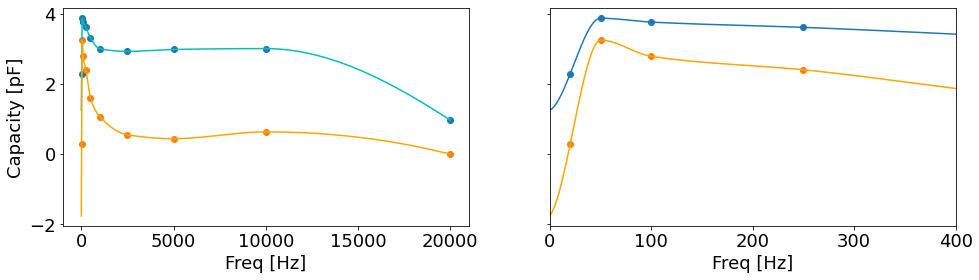

In [6]:
# New Capacities
C_lso = 1 #pF
caps_sbc = np.loadtxt('/home/ubuntu/cosyne-tutorial-2022/results_caps/caps_sbc')
caps_gbc = np.loadtxt('/home/ubuntu/cosyne-tutorial-2022/results_caps/caps_gbc')
freqs = [20,50,100,250,500,1000,2500,5000,10000,20000]
eq_cap_sbc = scp.interpolate.PchipInterpolator(freqs, caps_sbc)
eq_cap_gbc = scp.interpolate.PchipInterpolator(freqs, caps_gbc)
#freq = np.round(np.logspace(np.log(20),np.log(20000), num = 3500, base = np.exp(1)),2)
#plt.plot(freq, pi(freq))
fig, ax = plt.subplots(1,2, figsize = (16,4), sharey = True)
ax[0].scatter(freqs,caps_sbc)
ax[0].plot(np.arange(20000), eq_cap_sbc(np.arange(20000)), 'c')
ax[0].scatter(freqs,caps_gbc)
ax[0].plot(np.arange(20000), eq_cap_gbc(np.arange(20000)), 'orange')
ax[0].set_xlabel("Freq [Hz]")
ax[0].set_ylabel("Capacity [pF]")
ax[1].scatter(freqs,caps_sbc)
ax[1].scatter(freqs,caps_gbc)
ax[1].plot(np.arange(20000), eq_cap_sbc(np.arange(20000)))
ax[1].plot(np.arange(20000), eq_cap_gbc(np.arange(20000)), 'orange')
ax[1].set_xlabel("Freq [Hz]")
ax[1].set_xlim([0,400])

In [7]:
# Fixed
w_head = 22 #cm
v_sound = 33000 #cm/s

n_ANFs = 35000
ANFs2SBCs = 4
ANFs2GBCs = 20
SBCs2MSOs = int(ANFs2GBCs/ANFs2SBCs)
SBCs2LSOs = int(ANFs2GBCs/ANFs2SBCs)
n_SBCs = int(n_ANFs/ANFs2SBCs)
n_GBCs = int(n_ANFs/ANFs2GBCs)
n_MSOs = n_GBCs*n_battery

# Internal Populations

In [8]:
for tone in tones:
    
    C_m_scb = eq_cap_sbc(tone)
    C_m_gcb = eq_cap_gbc(tone)
    
    results_r_MSO = np.zeros((n_battery, len(angles)))
    results_l_MSO = np.zeros((n_battery, len(angles)))

    results_r_LSO = np.zeros(len(angles))
    results_l_LSO = np.zeros(len(angles))

    results_r_SBC = np.zeros(len(angles))
    results_l_SBC = np.zeros(len(angles))

    results_r_GBC = np.zeros(len(angles))
    results_l_GBC = np.zeros(len(angles))
    
    for angle in angles:

        nest.ResetKernel()
        nest.local_num_threads = 16
        nest.resolution = 0.001 # 10 us = minimum audible angle (MAA) increment of 1.25°

        freq = np.round(np.logspace(np.log(20),np.log(20000), num = 3500, base = np.exp(1)),2)
        channel_x = np.where(freq>=tone)[0][0]
        spectro = np.zeros((3500,time_sim))
        amplitudes = np.round(stats.norm.pdf(np.linspace(-1, 1, 21) , 0, 1.0/(math.sqrt(2*math.pi)*1)),2)

        if(channel_x<10):
            #spectro[channel_x, :] = np.ones(time_sim)
            spectro[channel_x:channel_x+10+1,:] = amplitudes[10:].reshape(11,1)*np.ones((11, time_sim))
            spectro[0:channel_x+1, :] = amplitudes[10-channel_x:11].reshape(channel_x+1,1)*np.ones((channel_x+1, time_sim))
        else:
            if(channel_x>3489):
                #spectro[channel_x, :] = np.ones(time_sim)
                spectro[channel_x-10:channel_x+1] = amplitudes[:11].reshape(11,1)*np.ones((11, time_sim))
                spectro[channel_x:] = amplitudes[10:10+3500-channel_x].reshape(3500-channel_x,1)*np.ones((3500-channel_x, time_sim))
            else:
                #spectro[channel_x, :] = np.ones(time_sim)
                spectro[channel_x - 10 : channel_x + 10 + 1, :] = amplitudes.reshape(21,1)*np.ones((21, time_sim))

        delta_x = (w_head*np.sin(np.deg2rad(angle)))
        itd = 1000*delta_x/v_sound #ms
        ipds = 2*np.pi*itd*freq/1000

        #itd = np.round(itd,2)
        
        # Populations
        
        #r_ANFs_amp = nest.Create("spike_generator", 1, params={"spike_times": np.arange(1.0,time_sim,1000/tone)})
        #l_ANFs_amp = nest.Create("spike_generator", 1, params={"spike_times": np.arange(1.0+itd,time_sim+itd,1000/tone)})

        r_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
                params={'frequency': np.repeat(freq, 10),
                            'phase': np.repeat(np.rad2deg(ipds),10)}) #ITDs

        l_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
                params={'frequency': np.repeat(freq, 10),
                            'phase': 0})
        
        r_ANFs = nest.Create('parrot_neuron', n_ANFs)

        l_ANFs = nest.Create('parrot_neuron', n_ANFs)

        r_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                         params = {'C_m': C_m_scb, 'V_reset': V_reset})

        l_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                         params = {'C_m': C_m_scb, 'V_reset': V_reset})

        r_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_m_gcb, 'V_reset': V_reset})

        l_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_m_gcb, 'V_reset': V_reset})


        r_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_m_gcb, 'V_reset': V_reset})

        l_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_m_gcb, 'V_reset': V_reset})

        r_MSO = nest.Create('iaf_cond_beta', n_MSOs, 
                         params = {'C_m': C_mso, 'tau_rise_ex' : taus[0], 'tau_rise_in' : taus[1], 'tau_decay_ex' : taus[2], 'tau_decay_in' : taus[3], 'V_reset': V_reset})

        l_MSO = nest.Create('iaf_cond_beta', n_MSOs, 
                         params = {'C_m': C_mso, 'tau_rise_ex' : taus[0], 'tau_rise_in' : taus[1], 'tau_decay_ex' : taus[2], 'tau_decay_in' : taus[3], 'V_reset': V_reset})

        r_LSO = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_lso, 'V_reset': V_reset})

        l_LSO = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_lso, 'V_m': V_m, 'V_reset': V_reset})

        ANFs_noise = nest.Create('poisson_generator',1,
                         params = {'rate':noise_rate})

        s_rec_r = nest.Create('spike_recorder')
        s_rec_l = nest.Create('spike_recorder')
        
        """m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
        nest.SetStatus(m, {'interval': 0.01})
        nest.Connect(m, r_MSO, 'all_to_all')"""

        #Connections
        
        #Devices Connections
        nest.Connect(r_ANFs, s_rec_r, 'all_to_all')
        nest.Connect(l_ANFs, s_rec_l, 'all_to_all')

        nest.Connect(r_SBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_SBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_GBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_GBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_MNTBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_MNTBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_MSO, s_rec_r, 'all_to_all')
        nest.Connect(l_MSO, s_rec_l, 'all_to_all')

        nest.Connect(r_LSO, s_rec_r, 'all_to_all')
        nest.Connect(l_LSO, s_rec_l, 'all_to_all')

        #ANFs

        nest.Connect(r_ANFs_amp, r_ANFs, 'one_to_one')
        nest.Connect(l_ANFs_amp, l_ANFs, 'one_to_one')
        
        #ANF_noise to parrots
        for i in range(len(spectro)-1):
            if(np.any(spectro[i][:] > 0)):
                nest.Connect(ANFs_noise, r_ANFs[10*i:10*(i+1)], 'all_to_all')
                nest.Connect(ANFs_noise, l_ANFs[10*i:10*(i+1)], 'all_to_all')
        #ANF_parrots to SBCs
        for i in range(n_SBCs):
            nest.Connect(r_ANFs[ANFs2SBCs*i:ANFs2SBCs*(i+1)], r_SBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})
            nest.Connect(l_ANFs[ANFs2SBCs*i:ANFs2SBCs*(i+1)], l_SBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})
        #ANF_parrots to GBCs
        for i in range(n_GBCs):
            nest.Connect(r_ANFs[ANFs2GBCs*i:ANFs2GBCs*(i+1)], r_GBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})
            nest.Connect(l_ANFs[ANFs2GBCs*i:ANFs2GBCs*(i+1)], l_GBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})
            
        #GBCs to MNTBCs
        nest.Connect(r_GBCs, r_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight, "delay": delays_mso[3]})
        nest.Connect(l_GBCs, l_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight, "delay": delays_mso[3]})

        #MSO
        for i in range(n_GBCs):
            for j in range(n_battery):
                
            #Right MSO
                #From SBCs (excitation):
                nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[0]}) #ipsilateral
                nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[2]}) #contralateral
                #From LNTBCs (inhibition)
                nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_inh_weight[j], "delay": delays_mso[1]}) #ipsilateral
                #From MNTBCs (inhibition)
                nest.Connect(l_MNTBCs[i], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":MNTBCs2MSO_weights[j], "delay": delays_mso[4]}) #contralateral
            
            #Left MSO
                #From SBCs (excitation):
                nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[0]}) #ipsilateral
                nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[2]}) #contralateral
                #From LNTBCs (inhibition)
                nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_inh_weight[j], "delay": delays_mso[1]}) #ipsilateral
                #From MNTBCs (inhibition)
                nest.Connect(r_MNTBCs[i], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":MNTBCs2MSO_weights[j], "delay": delays_mso[4]}) #contralateral

        #LSO   
        for i in range(0, n_GBCs):
            nest.Connect(r_SBCs[SBCs2LSOs*i:SBCs2LSOs*(i+1)], r_LSO[i], 'all_to_all', syn_spec = {"weight":SBCs2LSO_weight})
            nest.Connect(l_SBCs[SBCs2LSOs*i:SBCs2LSOs*(i+1)], l_LSO[i], 'all_to_all', syn_spec = {"weight":SBCs2LSO_weight})   

        nest.Connect(r_MNTBCs, l_LSO, 'one_to_one', syn_spec = {"weight":MNTBCs2LSO_weight})
        nest.Connect(l_MNTBCs, r_LSO, 'one_to_one', syn_spec = {"weight":MNTBCs2LSO_weight})

        mean_amplitude_r = 10*amp_rate #expfunc(0, *p_opt_r)
        mean_amplitude_l = 8*amp_rate #expfunc(0, *p_opt_l)

        for i in range(time_sim):
            input_set_up(spectro,i)
            nest.Simulate(1)

        data_r = s_rec_r.get('events')
        data_l = s_rec_l.get('events')

        id_r_ANF1 = r_ANFs[0].get('global_id')
        id_r_SBC1 = r_SBCs[0].get('global_id')
        id_r_GBC1 = r_GBCs[0].get('global_id')
        id_r_MNTBC1 = r_MNTBCs[0].get('global_id')
        id_r_MSO1 = r_MSO[0].get('global_id')
        id_r_LSO1 = r_LSO[0].get('global_id')

        id_l_ANF1 = l_ANFs[0].get('global_id')
        id_l_SBC1 = l_SBCs[0].get('global_id')
        id_l_GBC1 = l_GBCs[0].get('global_id')
        id_l_MNTBC1 = l_MNTBCs[0].get('global_id')
        id_l_MSO1 = l_MSO[0].get('global_id')
        id_l_LSO1 = l_LSO[0].get('global_id')


        # Active Cells
        ac_r_anf = np.unique(data_r['senders'][np.where((data_r['senders']<id_r_SBC1) & (data_r['senders']>=id_r_ANF1))])
        ac_l_anf = np.unique(data_l['senders'][np.where((data_l['senders']<id_l_SBC1) & (data_l['senders']>=id_l_ANF1))])

        ac_r_sbc = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_SBC1) & (data_r['senders']<id_r_GBC1))])
        ac_l_sbc = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_SBC1) & (data_l['senders']<id_l_GBC1))])

        ac_r_gbc = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_GBC1) & (data_r['senders']<id_r_MNTBC1))])
        ac_l_gbc = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_GBC1) & (data_l['senders']<id_l_MNTBC1))])

        ac_r_mntbc = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_MNTBC1) & (data_r['senders']<id_r_MSO1))])
        ac_l_mntbc = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_MNTBC1) & (data_l['senders']<id_l_MSO1))])


        # Global Rates
        rate_r_anf = len(data_r['times'][np.where((data_r['senders']<id_r_SBC1) & (data_r['senders']>=id_r_ANF1))])*1000/time_sim
        rate_l_anf = len(data_l['times'][np.where((data_l['senders']<id_l_SBC1) & (data_l['senders']>=id_l_ANF1))])*1000/time_sim

        rate_r_sbc = len(data_r['times'][np.where((data_r['senders']>=id_r_SBC1) & (data_r['senders']<id_r_GBC1))])*1000/time_sim
        rate_l_sbc = len(data_l['times'][np.where((data_l['senders']>=id_l_SBC1) & (data_l['senders']<id_l_GBC1))])*1000/time_sim

        rate_r_gbc = len(data_r['times'][np.where((data_r['senders']>=id_r_GBC1) & (data_r['senders']<id_r_MNTBC1))])*1000/time_sim
        rate_l_gbc = len(data_l['times'][np.where((data_l['senders']>=id_l_GBC1) & (data_l['senders']<id_l_MNTBC1))])*1000/time_sim

        rate_r_mntbc = len(data_r['times'][np.where((data_r['senders']>=id_r_MNTBC1) & (data_r['senders']<id_r_MSO1))])*1000/time_sim
        rate_l_mntbc = len(data_l['times'][np.where((data_l['senders']>=id_l_MNTBC1) & (data_l['senders']<id_l_MSO1))])*1000/time_sim


        #LSO
        
        #averaging on total number of active cells --> result: averege rate of the population
        rate_r_lso = len(data_r['times'][np.where(data_r['senders']>=id_r_LSO1)])/(time_sim)*1000
        rate_l_lso = len(data_l['times'][np.where(data_l['senders']>=id_l_LSO1)])/(time_sim)*1000

        ac_r_lso = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_LSO1))])
        ac_l_lso = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_LSO1))])


        #MSO

        #averaging on total number of active batteries --> result: battery with rates for each inh weight
        rate_r_mso = np.zeros(n_battery)
        rate_l_mso = np.zeros(n_battery)
        ac_r_mso = np.zeros((int(n_MSOs/n_battery),n_battery))
        ac_l_mso = np.zeros((int(n_MSOs/n_battery),n_battery))
        n_ac_r_mso = np.zeros(n_battery)
        n_ac_l_mso = np.zeros(n_battery)

        for i in range(int(n_MSOs/n_battery)): #n of batteries
            for j in range(n_battery): # neurons for battery
                if(id_r_MSO1+n_battery*i+j in data_r['senders']):
                    rate_r_mso[j] += (np.unique(data_r['senders'][np.where(data_r['senders'] == id_r_MSO1+n_battery*i+j)], return_counts= True)[1][0])
                    ac_r_mso[i,j] = id_r_MSO1 + i*n_battery + j
                    n_ac_r_mso[j] += 1
                else:
                    rate_r_mso[j] += 0
                if(id_l_MSO1+n_battery*i+j in data_l['senders']):
                    rate_l_mso[j] += (np.unique(data_l['senders'][np.where(data_l['senders'] == id_l_MSO1+n_battery*i+j)], return_counts= True)[1][0])
                    ac_l_mso[i,j] = id_l_MSO1 + i*n_battery + j
                    n_ac_l_mso[j] += 1
                else:
                    rate_l_mso[j] += 0  
        
        if(save):
            results_r_MSO[:, np.where(angles == angle)[0][0]] = rate_r_mso
            results_l_MSO[:, np.where(angles == angle)[0][0]] = rate_l_mso
            
    if(save):
        np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/MSO_r_freq_{}'.format(n_folder,tone), results_r_MSO)
        np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/MSO_l_freq_{}'.format(n_folder,tone), results_l_MSO)

""""
    # for computing capacities (n_folder 4)
    
    rates[0,tones.index(tone)] = rate_r_sbc
    rates[1,tones.index(tone)] = rate_l_sbc
    rates[2,tones.index(tone)] = rate_r_gbc
    rates[3,tones.index(tone)] = rate_l_gbc

    nacs[0,tones.index(tone)] = len(ac_r_sbc)
    nacs[1,tones.index(tone)] = len(ac_l_sbc)
    nacs[2,tones.index(tone)] = len(ac_r_gbc)
    nacs[3,tones.index(tone)] = len(ac_l_gbc)

    n_folder = 3 #capacities every single tone (deleted)

    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/rate_SBC_r_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [rate_r_sbc])
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/rate_GBC_r_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [rate_r_gbc])

    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/rate_SBC_l_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [rate_l_sbc])
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/rate_GBC_l_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [rate_l_gbc])


    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/nac_SBC_r_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [len(ac_r_sbc)])
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/nac_GBC_r_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [len(ac_r_gbc)])

    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/nac_SBC_l_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [len(ac_l_sbc)])
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/nac_GBC_l_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [len(ac_l_gbc)])


n_folder = 4

np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/rates_C_{}'.format(n_folder,C_m_bushy), rates)
np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/nacs_C_{}'.format(n_folder,C_m_bushy), nacs)"""


Apr 15 08:17:22 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.001 ms.

Apr 15 08:17:53 NodeManager::prepare_nodes [Info]: 
    Preparing 1225048 nodes for simulation.

Apr 15 08:17:54 SimulationManager::run [Warning]: 
    The requested simulation time is not an integer multiple of the minimal 
    delay in the network. This may result in inconsistent results under the 
    following conditions: (i) A network contains more than one source of 
    randomness, e.g., two different poisson_generators, and (ii) Simulate is 
    called repeatedly with simulation times that are not multiples of the 
    minimal delay.

Apr 15 08:17:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1225048
    Simulation time (ms): 1
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Apr 15 08:17:55 SimulationManager::run [Info]: 
    Simulation finished.

Apr 15 08:17:55 NodeManager::prepare_nodes [Info]: 
    Preparing 1225048 node

'"\n    # for computing capacities (n_folder 4)\n    \n    rates[0,tones.index(tone)] = rate_r_sbc\n    rates[1,tones.index(tone)] = rate_l_sbc\n    rates[2,tones.index(tone)] = rate_r_gbc\n    rates[3,tones.index(tone)] = rate_l_gbc\n\n    nacs[0,tones.index(tone)] = len(ac_r_sbc)\n    nacs[1,tones.index(tone)] = len(ac_l_sbc)\n    nacs[2,tones.index(tone)] = len(ac_r_gbc)\n    nacs[3,tones.index(tone)] = len(ac_l_gbc)\n\n    n_folder = 3 #capacities every single tone (deleted)\n\n    np.savetxt(\'/home/ubuntu/cosyne-tutorial-2022/results{}/rate_SBC_r_freq_{}_C_{}\'.format(n_folder, tone, C_m_bushy), [rate_r_sbc])\n    np.savetxt(\'/home/ubuntu/cosyne-tutorial-2022/results{}/rate_GBC_r_freq_{}_C_{}\'.format(n_folder, tone, C_m_bushy), [rate_r_gbc])\n\n    np.savetxt(\'/home/ubuntu/cosyne-tutorial-2022/results{}/rate_SBC_l_freq_{}_C_{}\'.format(n_folder, tone, C_m_bushy), [rate_l_sbc])\n    np.savetxt(\'/home/ubuntu/cosyne-tutorial-2022/results{}/rate_GBC_l_freq_{}_C_{}\'.format(n_fold

# Bushy Cells Behaviour

Text(0.5, 0, 'Time (ms)')

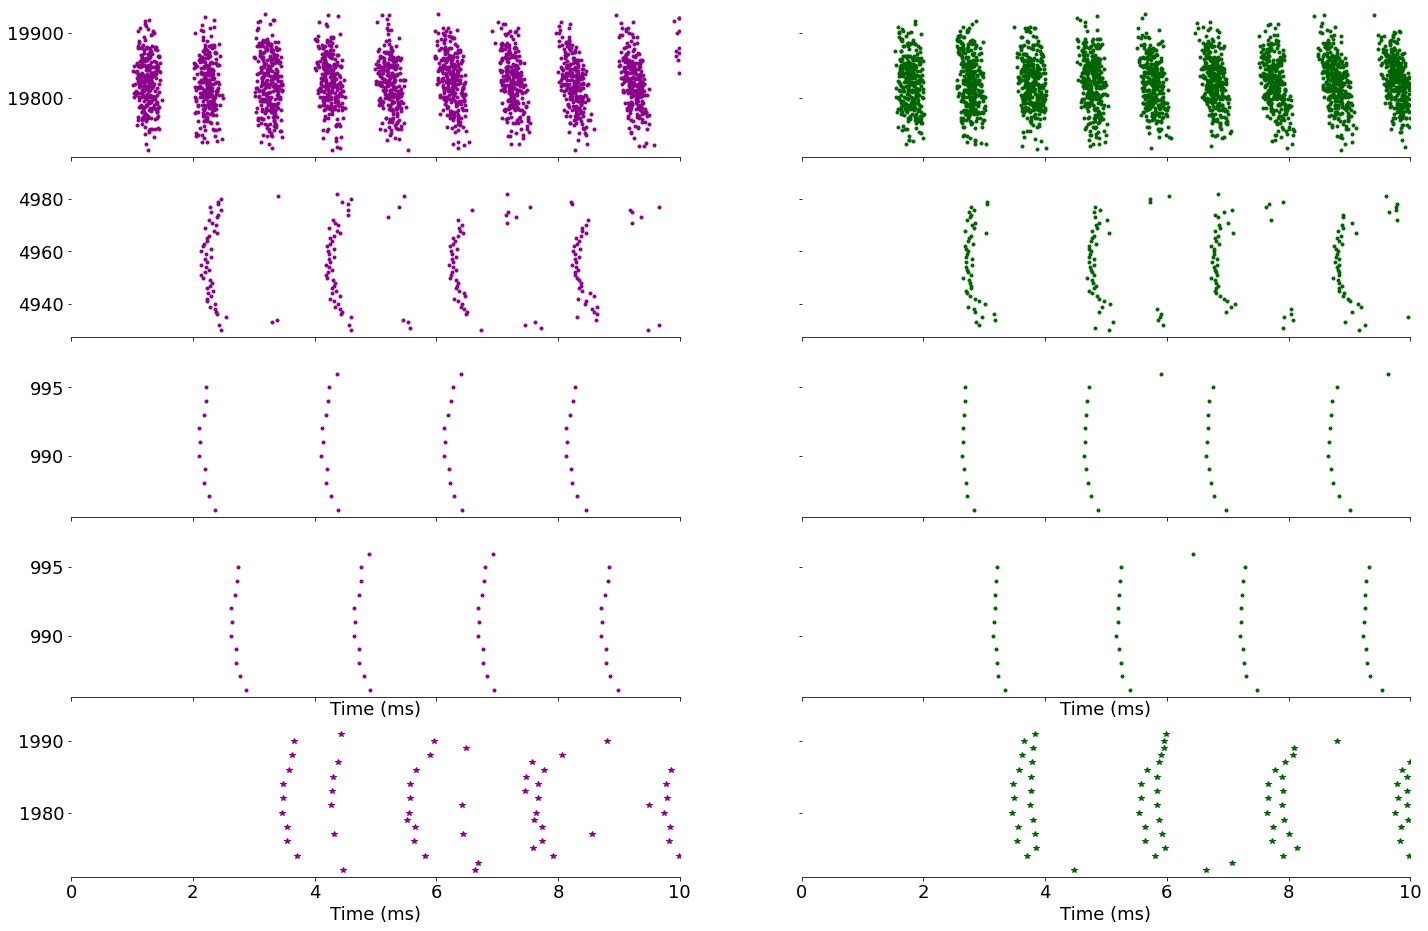

In [9]:
lim = 10

fig, ax = plt.subplots(5,2, figsize = (24,16), sharex = True, sharey = 'row')
plt.xlim(0,lim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].plot(data_l['times'][np.where(data_l['senders'] < id_l_SBC1)], data_l['senders'][np.where(data_l['senders'] < id_l_SBC1)] - id_l_ANF1, ".", color = 'darkmagenta')


ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_SBC1) & (data_l['senders'] < id_l_GBC1))], data_l['senders'][np.where((data_l['senders'] >= id_l_SBC1) & (data_l['senders'] < id_l_GBC1))]  - id_l_SBC1, ".", color = 'darkmagenta')


ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_GBC1) & (data_l['senders'] < id_l_MNTBC1))], data_l['senders'][np.where((data_l['senders'] >= id_l_GBC1) & (data_l['senders'] < id_l_MNTBC1))]  - id_l_GBC1, ".", color = 'darkmagenta')


ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_MNTBC1) & (data_l['senders'] < id_l_MSO1))], data_l['senders'][np.where((data_l['senders'] >= id_l_MNTBC1) & (data_l['senders'] < id_l_MSO1))] - id_l_MNTBC1, ".", color = 'darkmagenta')
ax[3,0].set_xlabel("Time (ms)")

ax[4,0].spines['top'].set_visible(False)
ax[4,0].spines['right'].set_visible(False)
ax[4,0].spines['left'].set_visible(False)
ax[4,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_MSO1) & (data_l['senders'] < id_l_LSO1))], data_l['senders'][np.where((data_l['senders'] >= id_l_MSO1) & (data_l['senders'] < id_l_LSO1))] - id_l_MSO1, "*", color = 'darkmagenta')
ax[4,0].set_xlabel("Time (ms)")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].plot(data_r['times'][np.where(data_r['senders'] < id_r_SBC1)], data_r['senders'][np.where(data_r['senders'] < id_r_SBC1)] - id_r_ANF1, ".", color = 'darkgreen')

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_SBC1) & (data_r['senders'] < id_r_GBC1))], data_r['senders'][np.where((data_r['senders'] >= id_r_SBC1) & (data_r['senders'] < id_r_GBC1))] - id_r_SBC1, ".", color = 'darkgreen')


ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_GBC1) & (data_r['senders'] < id_r_MNTBC1))], data_r['senders'][np.where((data_r['senders'] >= id_r_GBC1) & (data_r['senders'] < id_r_MNTBC1))] - id_r_GBC1, ".", color = 'darkgreen')


ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_MNTBC1) & (data_r['senders'] < id_r_MSO1))], data_r['senders'][np.where((data_r['senders'] >= id_r_MNTBC1) & (data_r['senders'] < id_r_MSO1))] - id_r_MNTBC1, ".", color = 'darkgreen')
ax[3,1].set_xlabel("Time (ms)")

ax[4,1].spines['top'].set_visible(False)
ax[4,1].spines['right'].set_visible(False)
ax[4,1].spines['left'].set_visible(False)
ax[4,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_MSO1) & (data_r['senders'] < id_r_LSO1))], data_r['senders'][np.where((data_r['senders'] >= id_r_MSO1) & (data_r['senders'] < id_r_LSO1))] - id_r_MSO1, "*", color = 'darkgreen')
ax[4,1].set_xlabel("Time (ms)")

#plt.savefig('plot.png', transparent=True)

In [10]:
itd

0.4714045207910316

In [11]:
2*np.pi*itd*100/1000

0.2961921958772244

In [12]:
channel_x

1982

In [13]:
ipds[channel_x] #diff dovuta al fatto che freq[816] non è esattamente 100 Hz

2.9644692116567875

In [14]:
print('ANFs spike times:')
print(np.sort(data_l['times'][np.where(data_l['senders'] < id_l_SBC1)]))
np.savetxt('/home/ubuntu/cosyne-tutorial-2022/{}_{}'.format(angle, 'l_ANFhh'), np.sort(data_l['times'][np.where(data_l['senders'] < id_l_SBC1)]))
print('SBCs spike times:')
print(np.sort(data_l['times'][np.where((data_l['senders'] >= id_l_SBC1) & (data_l['senders'] < id_l_GBC1))]))
np.savetxt('/home/ubuntu/cosyne-tutorial-2022/{}_{}'.format(angle, 'l_SBChh'), np.sort(data_l['times'][np.where((data_l['senders'] >= id_l_SBC1) & (data_l['senders'] < id_l_GBC1))]))
print('GBCs spike times:')
print(np.sort(data_l['times'][np.where((data_l['senders'] >= id_l_GBC1) & (data_l['senders'] < id_l_MNTBC1))]))
np.savetxt('/home/ubuntu/cosyne-tutorial-2022/{}_{}'.format(angle, 'l_GBChh'), np.sort(data_l['times'][np.where((data_l['senders'] >= id_l_GBC1) & (data_l['senders'] < id_l_MNTBC1))]))

ANFs spike times:
[1.02  1.021 1.032 ... 9.989 9.991 9.991]
SBCs spike times:
[2.135 2.138 2.142 2.168 2.175 2.185 2.193 2.197 2.203 2.21  2.217 2.225
 2.226 2.235 2.235 2.236 2.241 2.251 2.258 2.27  2.272 2.279 2.283 2.285
 2.286 2.291 2.293 2.297 2.298 2.311 2.323 2.339 2.348 2.361 2.363 2.376
 2.389 2.395 2.396 2.404 2.407 2.412 2.415 2.424 2.457 2.46  2.467 2.552
 3.305 3.378 3.398 4.191 4.191 4.2   4.21  4.216 4.216 4.23  4.231 4.24
 4.241 4.255 4.255 4.257 4.257 4.281 4.282 4.286 4.287 4.299 4.309 4.312
 4.313 4.315 4.322 4.326 4.329 4.339 4.342 4.357 4.364 4.373 4.39  4.39
 4.413 4.415 4.425 4.439 4.446 4.448 4.543 4.548 4.548 4.566 4.591 4.595
 4.604 5.207 5.395 5.452 5.47  5.535 5.561 6.207 6.226 6.227 6.238 6.246
 6.25  6.253 6.265 6.266 6.272 6.277 6.28  6.297 6.309 6.316 6.325 6.326
 6.33  6.336 6.338 6.358 6.359 6.36  6.361 6.376 6.379 6.386 6.402 6.414
 6.427 6.441 6.454 6.458 6.474 6.493 6.502 6.591 6.736 7.137 7.168 7.169
 7.173 7.308 7.464 7.547 7.615 7.712 8.214 8.222

In [15]:
print('ANFs spike times:')
print(np.sort(data_r['times'][np.where(data_r['senders'] < id_r_SBC1)]))
np.savetxt('/home/ubuntu/cosyne-tutorial-2022/{}_{}'.format(angle, 'r_ANFhh'), np.sort(data_r['times'][np.where(data_r['senders'] < id_r_SBC1)]))
print('SBCs spike times:')
print(np.sort(data_r['times'][np.where((data_r['senders'] >= id_r_SBC1) & (data_r['senders'] < id_r_GBC1))]))
np.savetxt('/home/ubuntu/cosyne-tutorial-2022/{}_{}'.format(angle, 'r_SBChh'), np.sort(data_r['times'][np.where((data_r['senders'] >= id_r_SBC1) & (data_r['senders'] < id_r_GBC1))]))
print('GBCs spike times:')
print(np.sort(data_r['times'][np.where((data_r['senders'] >= id_r_GBC1) & (data_r['senders'] < id_r_MNTBC1))]))
np.savetxt('/home/ubuntu/cosyne-tutorial-2022/{}_{}'.format(angle, 'r_GBChh'), np.sort(data_r['times'][np.where((data_r['senders'] >= id_r_GBC1) & (data_r['senders'] < id_r_MNTBC1))]))

ANFs spike times:
[1.532 1.545 1.55  ... 9.986 9.986 9.998]
SBCs spike times:
[2.66  2.679 2.688 2.696 2.703 2.706 2.706 2.709 2.712 2.713 2.721 2.723
 2.734 2.737 2.738 2.74  2.743 2.745 2.752 2.767 2.771 2.772 2.776 2.777
 2.778 2.778 2.789 2.791 2.792 2.797 2.807 2.817 2.825 2.829 2.839 2.844
 2.846 2.853 2.868 2.918 2.92  2.958 3.019 3.03  3.052 3.054 3.164 3.182
 4.689 4.714 4.726 4.727 4.729 4.729 4.741 4.745 4.754 4.759 4.762 4.765
 4.766 4.767 4.771 4.771 4.788 4.797 4.805 4.807 4.808 4.811 4.812 4.815
 4.823 4.824 4.832 4.832 4.843 4.847 4.859 4.882 4.887 4.892 4.911 4.93
 4.963 5.022 5.051 5.051 5.07  5.114 5.722 5.728 5.84  5.857 5.884 5.903
 5.942 6.043 6.721 6.729 6.745 6.764 6.768 6.771 6.771 6.779 6.785 6.787
 6.794 6.797 6.797 6.8   6.802 6.802 6.804 6.809 6.814 6.821 6.824 6.824
 6.835 6.835 6.836 6.845 6.854 6.86  6.868 6.882 6.935 6.94  6.979 6.981
 7.001 7.049 7.067 7.08  7.119 7.638 7.683 7.708 7.903 7.917 7.931 8.034
 8.039 8.074 8.736 8.747 8.769 8.773 8.788 8.78

In [16]:
print("Active ANFs l/r: ", len(ac_l_anf), "cells/", len(ac_r_anf), "cells")
print("Active SBCs l/r: ", len(ac_l_sbc), "cells /", len(ac_r_sbc), "cells")
print("Active GBCs l/r: ", len(ac_l_gbc), "cells /", len(ac_r_gbc), "cells")
print("Active MNTBCs l/r: ", len(ac_l_mntbc), "cells /", len(ac_r_mntbc), "cells")

Active ANFs l/r:  206 cells/ 202 cells
Active SBCs l/r:  53 cells / 53 cells
Active GBCs l/r:  11 cells / 11 cells
Active MNTBCs l/r:  11 cells / 11 cells


In [17]:
print("Activty ANFs l/r: ", rate_l_anf*time_sim/1000, "spikes/", rate_r_anf*time_sim/1000, "spikes")
print("Activty SBCs l/r: ", rate_l_sbc*time_sim/1000, "spikes/", rate_r_sbc*time_sim/1000, "spikes")
print("Activty GBCs l/r: ", rate_l_gbc*time_sim/1000, "spikes/", rate_r_gbc*time_sim/1000, "spikes")
print("Activty MNTBCs l/r: ", rate_l_mntbc*time_sim/1000, "spikes/", rate_r_mntbc*time_sim/1000, "spikes")

Activty ANFs l/r:  2299.0 spikes/ 2859.0 spikes
Activty SBCs l/r:  197.0 spikes/ 192.0 spikes
Activty GBCs l/r:  42.0 spikes/ 42.0 spikes
Activty MNTBCs l/r:  42.0 spikes/ 41.0 spikes


In [18]:
for j in range(len(MNTBCs2MSO_weights)):
    print("Inhibition Weight:", MNTBCs2MSO_weights[j], "nS")
    print("Activty MSOs l/r: ", rate_l_mso[j], "spikes /", rate_r_mso[j], "spikes")
    print("Active MSOs l/r: ", n_ac_l_mso[j], "cells/", n_ac_r_mso[j], "cells")
    print("Rate MSOs l/r: ", int(rate_l_mso[j]/n_ac_l_mso[j]), "Hz /", int(rate_r_mso[j]/n_ac_r_mso[j]), "Hz")
    print("----------------------------------------------\n")

Inhibition Weight: 0 nS
Activty MSOs l/r:  36.0 spikes / 36.0 spikes
Active MSOs l/r:  10.0 cells/ 10.0 cells
Rate MSOs l/r:  3 Hz / 3 Hz
----------------------------------------------

Inhibition Weight: -30 nS
Activty MSOs l/r:  18.0 spikes / 32.0 spikes
Active MSOs l/r:  10.0 cells/ 10.0 cells
Rate MSOs l/r:  1 Hz / 3 Hz
----------------------------------------------



# Internal Populations

In [19]:
print("Rate ANFs l/r: ", int(rate_l_anf/len(ac_l_anf)), "Hz /", int(rate_r_anf/len(ac_r_anf)), "Hz")
print("Rate SBCs l/r: ", int(rate_l_sbc/len(ac_l_sbc)), "Hz /", int(rate_r_sbc/len(ac_r_sbc)), "Hz")
print("Rate GBCs l/r: ", int(rate_l_gbc/len(ac_l_gbc)), "Hz /", int(rate_r_gbc/len(ac_r_gbc)), "Hz")
print("Rate MNTBCs l/r: ", int(rate_l_mntbc/len(ac_l_mntbc)), "Hz /", int(rate_r_mntbc/len(ac_r_mntbc)), "Hz")
j = 0
print("----------------------------------------------")
print("Inhibition Weight:", MNTBCs2MSO_weights[j], "nS")
print("Activty MSOs l/r: ", rate_l_mso[j], "spikes /", rate_r_mso[j], "spikes")
print("Active MSOs l/r: ", n_ac_l_mso[j], "cells/", n_ac_r_mso[j], "cells")
print("Rate MSOs l/r: ", int(rate_l_mso[j]/n_ac_l_mso[j]), "Hz /", int(rate_r_mso[j]/n_ac_r_mso[j]), "Hz")

Rate ANFs l/r:  1116 Hz / 1415 Hz
Rate SBCs l/r:  371 Hz / 362 Hz
Rate GBCs l/r:  381 Hz / 381 Hz
Rate MNTBCs l/r:  381 Hz / 372 Hz
----------------------------------------------
Inhibition Weight: 0 nS
Activty MSOs l/r:  36.0 spikes / 36.0 spikes
Active MSOs l/r:  10.0 cells/ 10.0 cells
Rate MSOs l/r:  3 Hz / 3 Hz


In [20]:
bin_dim = 0.1 #ms

hist_r_ANFs = np.zeros(int(time_sim/bin_dim))
hist_l_ANFs = np.zeros(int(time_sim/bin_dim))

for i in ac_r_anf:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_r_ANFs = hist_r_ANFs + s_r
    
for i in ac_l_anf:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_l_ANFs = hist_l_ANFs + s_l
    
hist_r_SBCs = np.zeros(int(time_sim/bin_dim))
hist_l_SBCs = np.zeros(int(time_sim/bin_dim))

for i in ac_r_sbc:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_r_SBCs = hist_r_SBCs + s_r
    
for i in ac_l_sbc:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_l_SBCs = hist_l_SBCs + s_l
    
hist_r_GBCs = np.zeros(int(time_sim/bin_dim))
hist_l_GBCs = np.zeros(int(time_sim/bin_dim))

for i in ac_r_gbc:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_r_GBCs = hist_r_GBCs + s_r
    
for i in ac_l_gbc:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_l_GBCs = hist_l_GBCs + s_l

hist_r_MNTBCs = np.zeros(int(time_sim/bin_dim))
hist_l_MNTBCs = np.zeros(int(time_sim/bin_dim))

for i in ac_r_mntbc:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_r_MNTBCs = hist_r_MNTBCs + s_r
    
    
for i in ac_l_mntbc:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_l_MNTBCs = hist_l_MNTBCs + s_l

Text(0.5, 0, 'Time [ms]')

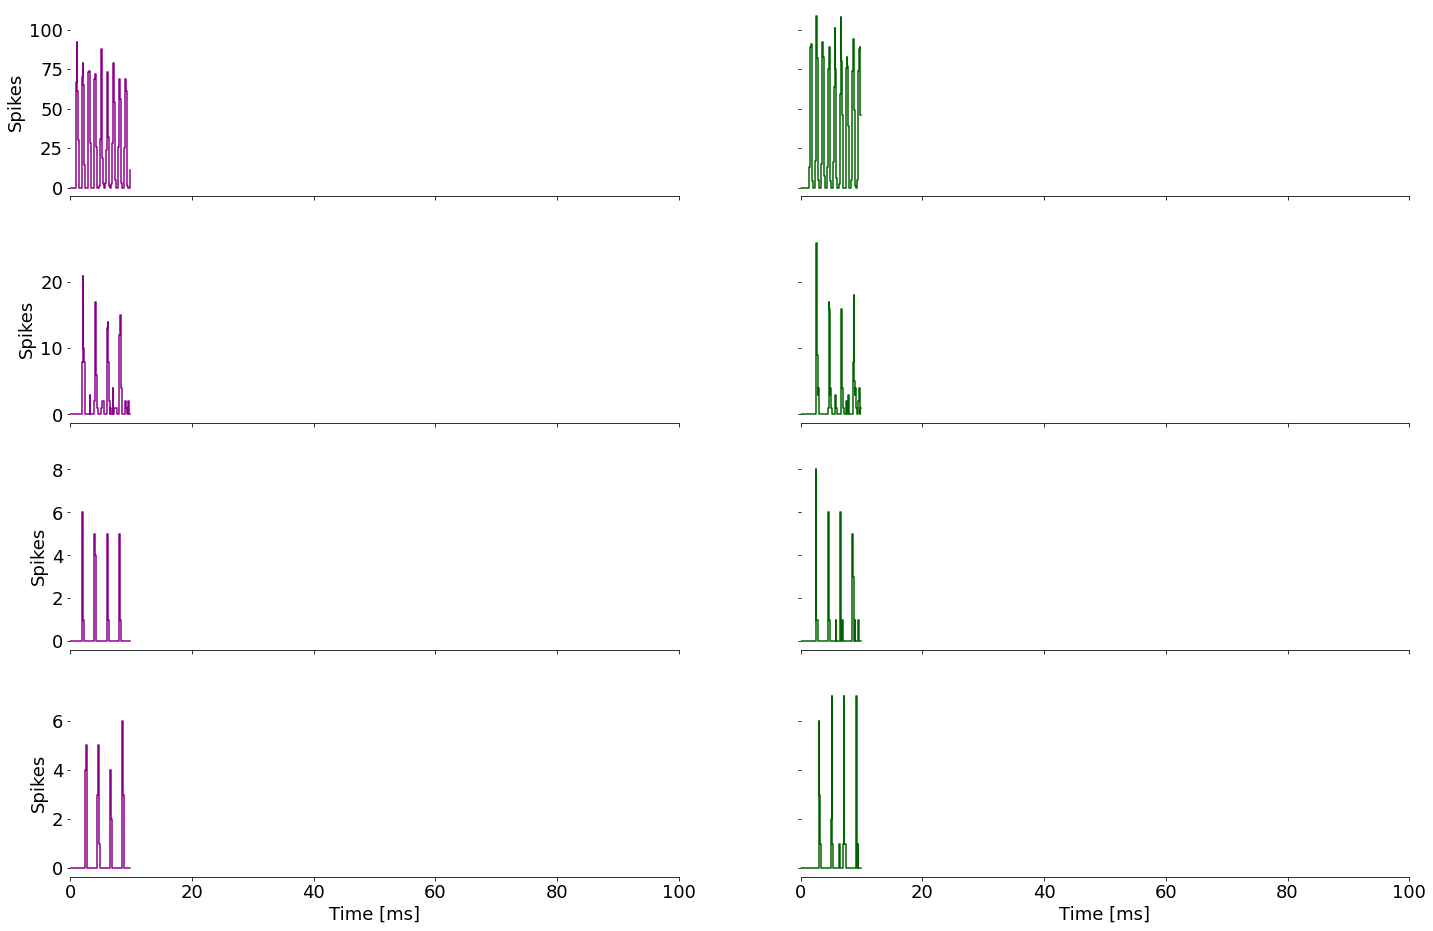

In [21]:
lim = 100

text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(4,2, figsize = (24,16), sharex = True, sharey = 'row')
plt.xlim(0,lim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].step(bins[:-1], hist_l_ANFs, color = 'darkmagenta')
ax[0,0].set_ylabel("Spikes")

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].step(bins[:-1], hist_l_SBCs, color = 'darkmagenta')
ax[1,0].set_ylabel("Spikes")

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].step(bins[:-1], hist_l_GBCs, color = 'darkmagenta')
ax[2,0].set_ylabel("Spikes")

ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].step(bins[:-1], hist_l_MNTBCs, color = 'darkmagenta')
ax[3,0].set_ylabel("Spikes")
ax[3,0].set_xlabel("Time [ms]")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].step(bins[:-1], hist_r_ANFs, color = 'darkgreen')

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].step(bins[:-1], hist_r_SBCs, color = 'darkgreen')

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].step(bins[:-1], hist_r_GBCs, color = 'darkgreen')

ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].step(bins[:-1], hist_r_MNTBCs, color = 'darkgreen')
ax[3,1].set_xlabel("Time [ms]")

Text(0.5, 0, 'Time [ms]')

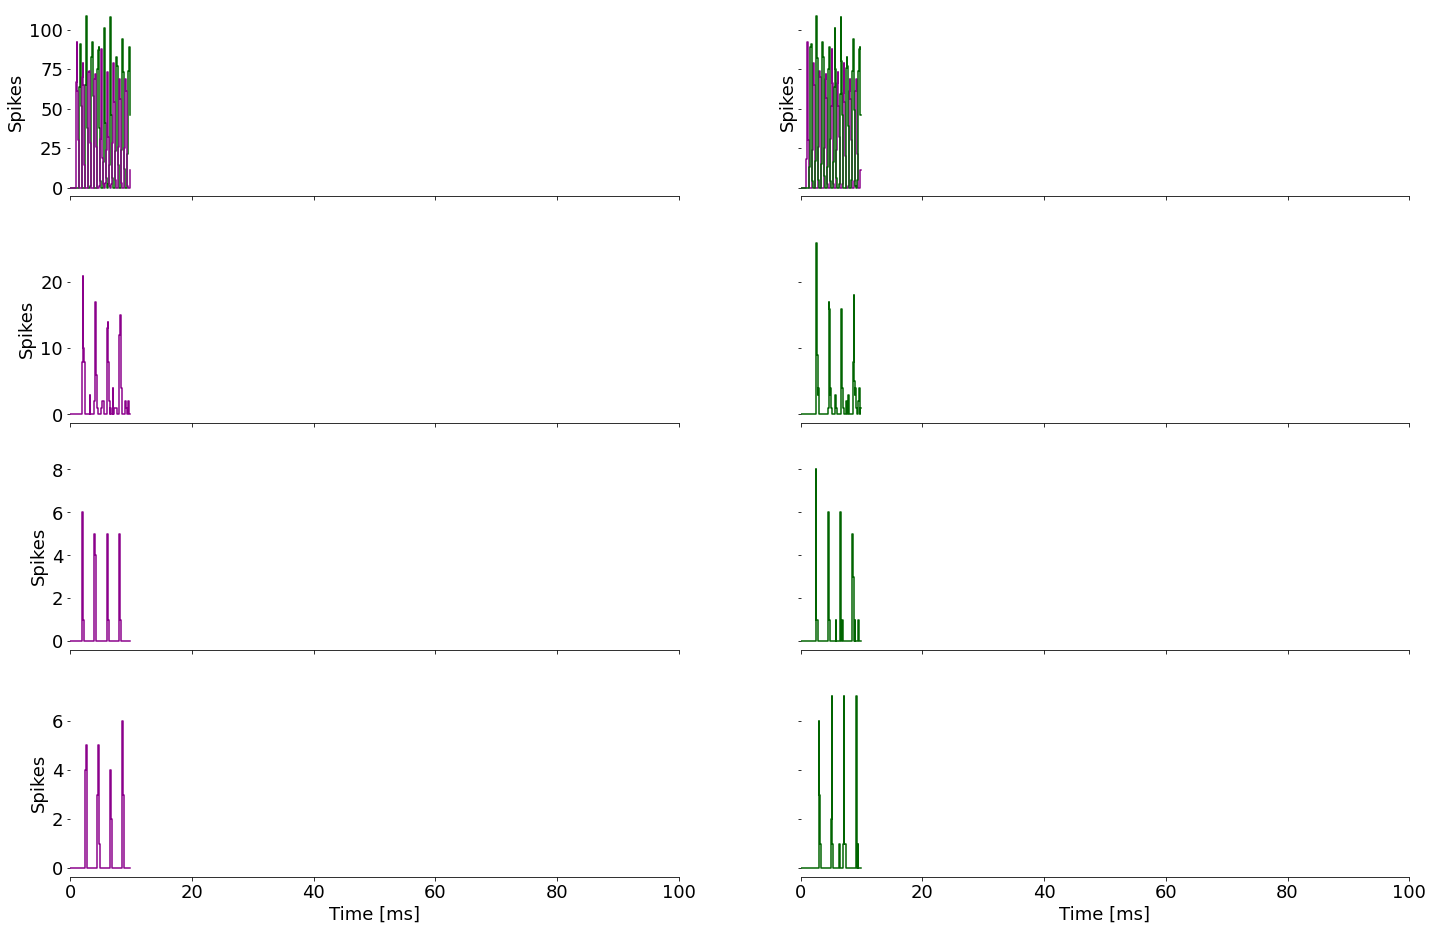

In [22]:
lim = 100

text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(4,2, figsize = (24,16), sharex = True, sharey = 'row')
plt.xlim(0,lim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].step(bins[:-1], hist_r_ANFs, color = 'darkgreen')

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].step(bins[:-1], hist_l_ANFs, color = 'darkmagenta')
ax[0,0].set_ylabel("Spikes")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].step(bins[:-1], hist_l_ANFs, color = 'darkmagenta')
ax[0,1].set_ylabel("Spikes")

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].step(bins[:-1], hist_l_SBCs, color = 'darkmagenta')
ax[1,0].set_ylabel("Spikes")

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].step(bins[:-1], hist_l_GBCs, color = 'darkmagenta')
ax[2,0].set_ylabel("Spikes")

ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].step(bins[:-1], hist_l_MNTBCs, color = 'darkmagenta')
ax[3,0].set_ylabel("Spikes")
ax[3,0].set_xlabel("Time [ms]")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].step(bins[:-1], hist_r_ANFs, color = 'darkgreen')

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].step(bins[:-1], hist_r_SBCs, color = 'darkgreen')

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].step(bins[:-1], hist_r_GBCs, color = 'darkgreen')

ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].step(bins[:-1], hist_r_MNTBCs, color = 'darkgreen')
ax[3,1].set_xlabel("Time [ms]")

In [23]:
hist_r_ANFs = hist_r_ANFs/len(ac_r_anf)
hist_l_ANFs = hist_l_ANFs/len(ac_l_anf)

hist_r_SBCs = hist_r_SBCs/len(ac_r_sbc)
hist_l_SBCs = hist_l_SBCs/len(ac_l_sbc)

hist_r_GBCs = hist_r_GBCs/len(ac_r_gbc)
hist_l_GBCs = hist_l_GBCs/len(ac_l_gbc)

hist_r_MNTBCs = hist_r_MNTBCs/len(ac_r_mntbc)
hist_l_MNTBCs = hist_l_MNTBCs/len(ac_l_mntbc)

Text(0.5, 0, 'Time [ms]')

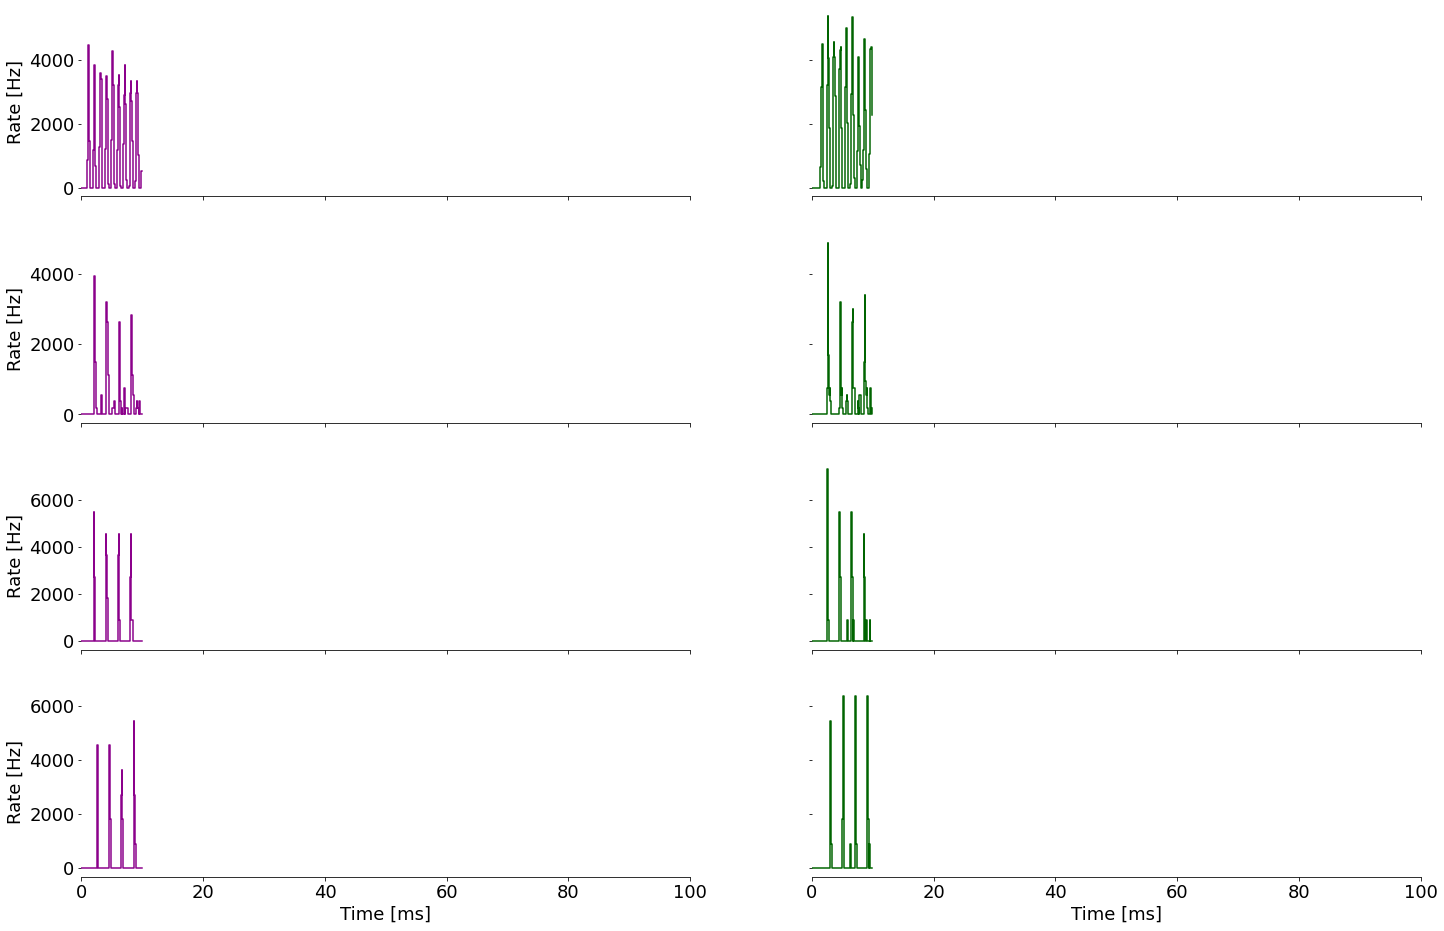

In [24]:
lim = 100

text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(4,2, figsize = (24,16), sharex = True, sharey = 'row')
plt.xlim(0,lim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].step(bins[:-1], hist_l_ANFs*1000/bin_dim, color = 'darkmagenta')
ax[0,0].set_ylabel("Rate [Hz]")

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].step(bins[:-1], hist_l_SBCs*1000/bin_dim, color = 'darkmagenta')
ax[1,0].set_ylabel("Rate [Hz]")

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].step(bins[:-1], hist_l_GBCs*1000/bin_dim, color = 'darkmagenta')
ax[2,0].set_ylabel("Rate [Hz]")

ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].step(bins[:-1], hist_l_MNTBCs*1000/bin_dim, color = 'darkmagenta')
ax[3,0].set_ylabel("Rate [Hz]")
ax[3,0].set_xlabel("Time [ms]")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].step(bins[:-1], hist_r_ANFs*1000/bin_dim, color = 'darkgreen')

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].step(bins[:-1], hist_r_SBCs*1000/bin_dim, color = 'darkgreen')

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].step(bins[:-1], hist_r_GBCs*1000/bin_dim, color = 'darkgreen')

ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].step(bins[:-1], hist_r_MNTBCs*1000/bin_dim, color = 'darkgreen')
ax[3,1].set_xlabel("Time [ms]")

Text(0.5, 0, 'Time [ms]')

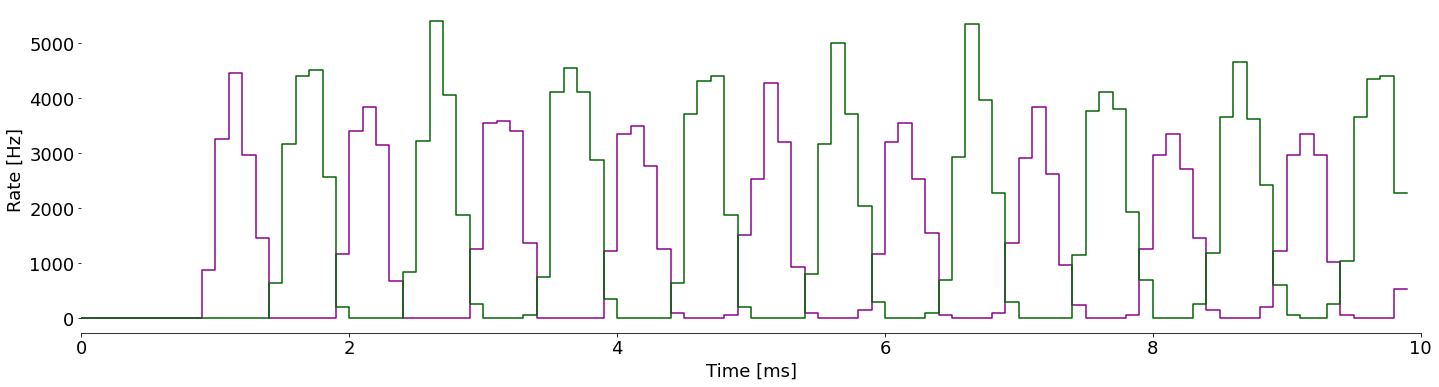

In [25]:
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(1,figsize = (24,6), sharex = 'col', sharey = 'row')
plt.xlim(0,time_sim)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.step(bins[:-1], hist_l_ANFs*1000/bin_dim, color = 'darkmagenta')
ax.set_ylabel("Rate [Hz]")
ax.step(bins[:-1], hist_r_ANFs*1000/bin_dim, color = 'darkgreen')
ax.set_xlabel("Time [ms]")

# MSOs

In [26]:
for j in range(len(MNTBCs2MSO_weights)):
    print("Inhibition Weight:", MNTBCs2MSO_weights[j], "nS")
    print("Activty MSOs l/r: ", rate_l_mso[j], "spikes /", rate_r_mso[j], "spikes")
    print("Active MSOs l/r: ", n_ac_l_mso[j], "cells/", n_ac_r_mso[j], "cells")
    print("Rate MSOs l/r: ", int(rate_l_mso[j]/n_ac_l_mso[j]), "Hz /", int(rate_r_mso[j]/n_ac_r_mso[j]), "Hz")
    print("----------------------------------------------\n")

Inhibition Weight: 0 nS
Activty MSOs l/r:  36.0 spikes / 36.0 spikes
Active MSOs l/r:  10.0 cells/ 10.0 cells
Rate MSOs l/r:  3 Hz / 3 Hz
----------------------------------------------

Inhibition Weight: -30 nS
Activty MSOs l/r:  18.0 spikes / 32.0 spikes
Active MSOs l/r:  10.0 cells/ 10.0 cells
Rate MSOs l/r:  1 Hz / 3 Hz
----------------------------------------------



In [27]:
hist_r_MSOs = np.zeros((len(MNTBCs2MSO_weights), int(time_sim/bin_dim)))
hist_l_MSOs = np.zeros((len(MNTBCs2MSO_weights), int(time_sim/bin_dim)))

for i in range(ac_r_mso.shape[0]):
    for j in range(ac_r_mso.shape[1]):
        t_r = data_r['times'][np.where(data_r['senders'] == ac_r_mso[i,j])]
        s_r, bins = np.histogram(t_r, np.arange(0,time_sim+bin_dim,bin_dim))
        hist_r_MSOs[j] = hist_r_MSOs[j] + s_r
        
        """"if(ac_r_mso[i,j]!=0):
            print(ac_r_mso[i,j])
            print(t_r)
            print(hist_r_MSOs[j])
            print("------------------")"""

for i in range(ac_l_mso.shape[0]):
    for j in range(ac_l_mso.shape[1]):
        t_l = data_l['times'][np.where(data_l['senders'] == ac_l_mso[i,j])]
        s_l, bins = np.histogram(t_l, np.arange(0,time_sim+bin_dim,bin_dim))
        hist_l_MSOs[j] = hist_l_MSOs[j] + s_l
        
for j in range(ac_l_mso.shape[1]):
    hist_r_MSOs[j]/=n_ac_r_mso[j]
    hist_l_MSOs[j]/=n_ac_l_mso[j]

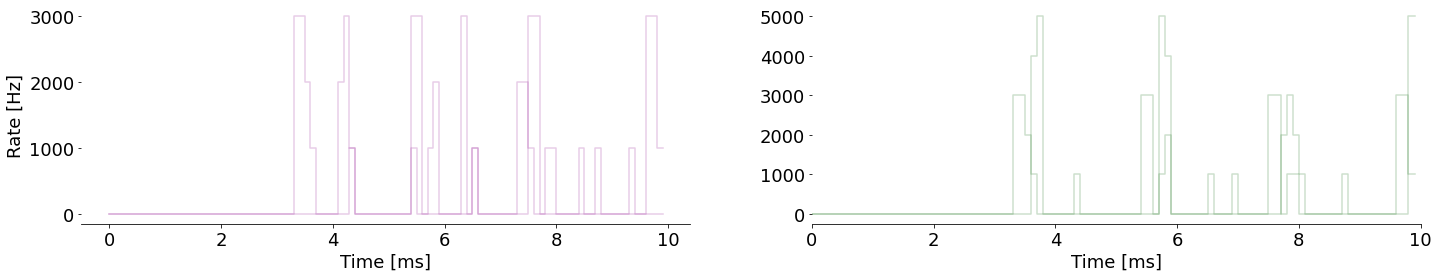

In [28]:
fig, ax = plt.subplots(1,2,figsize = (24,4))
plt.xlim(0,time_sim)

for j in range(len(MNTBCs2MSO_weights)):
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].step(bins[:-1], hist_l_MSOs[j]*1000/bin_dim, color = 'darkmagenta', alpha=0.2)
    ax[0].set_xlabel("Time [ms]")
    ax[0].set_ylabel("Rate [Hz]")

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].step(bins[:-1], hist_r_MSOs[j]*1000/bin_dim, color = 'darkgreen', alpha=0.2)
    ax[1].set_xlabel("Time [ms]")

NameError: name 'hist_l_LSOs' is not defined

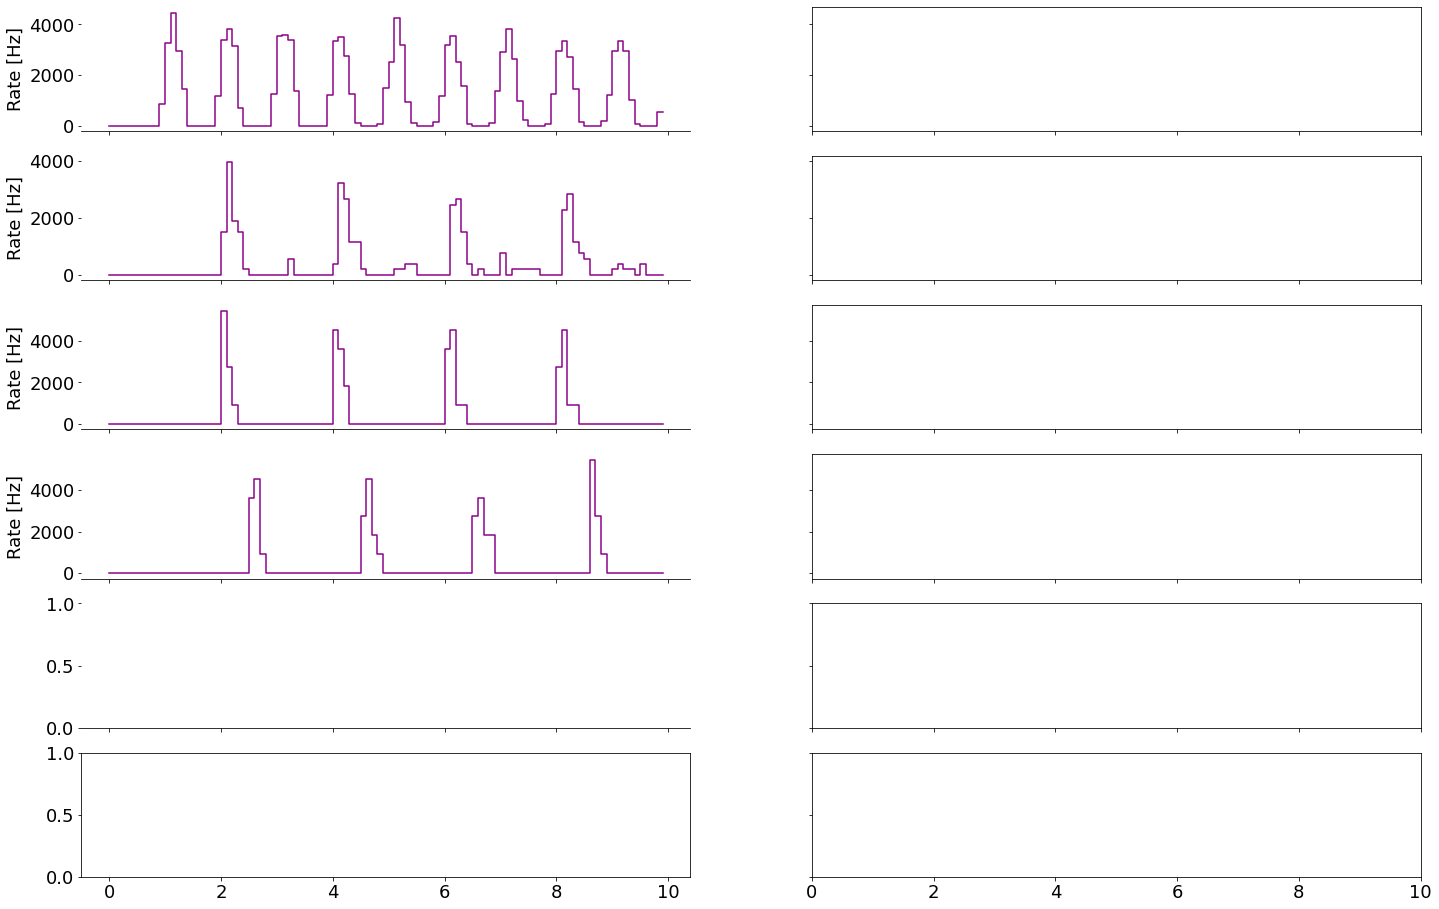

In [29]:
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(6,2, figsize = (24,16), sharex = 'col', sharey = 'row')
plt.xlim(0,time_sim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].step(bins[:-1], hist_l_ANFs*1000/bin_dim, color = 'darkmagenta')
ax[0,0].set_ylabel("Rate [Hz]")

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].step(bins[:-1], hist_l_SBCs*1000/bin_dim, color = 'darkmagenta')
ax[1,0].set_ylabel("Rate [Hz]")

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].step(bins[:-1], hist_l_GBCs*1000/bin_dim, color = 'darkmagenta')
ax[2,0].set_ylabel("Rate [Hz]")

ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].step(bins[:-1], hist_l_MNTBCs*1000/bin_dim, color = 'darkmagenta')
ax[3,0].set_ylabel("Rate [Hz]")

ax[4,0].spines['top'].set_visible(False)
ax[4,0].spines['right'].set_visible(False)
ax[4,0].spines['left'].set_visible(False)
ax[4,0].step(bins[:-1], hist_l_LSOs*1000/bin_dim, color = 'darkmagenta')
ax[4,0].set_ylabel("Rate [Hz]")

ax[5,0].spines['top'].set_visible(False)
ax[5,0].spines['right'].set_visible(False)
ax[5,0].spines['left'].set_visible(False)
ax[5,0].step(bins[:-1], hist_l_MSOs[0]*1000/bin_dim, color = 'darkmagenta')
ax[5,0].set_ylabel("Rate [Hz]")
ax[5,0].set_xlabel("Time [ms]")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].step(bins[:-1], hist_r_ANFs*1000/bin_dim, color = 'darkgreen')

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].step(bins[:-1], hist_r_SBCs*1000/bin_dim, color = 'darkgreen')

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].step(bins[:-1], hist_r_GBCs*1000/bin_dim, color = 'darkgreen')

ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].step(bins[:-1], hist_r_MNTBCs*1000/bin_dim, color = 'darkgreen')

ax[4,1].spines['top'].set_visible(False)
ax[4,1].spines['right'].set_visible(False)
ax[4,1].spines['left'].set_visible(False)
ax[4,1].step(bins[:-1], hist_r_LSOs*1000/bin_dim, color = 'darkgreen')

ax[5,1].spines['top'].set_visible(False)
ax[5,1].spines['right'].set_visible(False)
ax[5,1].spines['left'].set_visible(False)
ax[5,1].step(bins[:-1], hist_r_MSOs[0]*1000/bin_dim, color = 'darkgreen')
ax[5,1].set_xlabel("Time [ms]")

# LSOs

In [ ]:
print("Activty LSOs l/r: ", rate_l_lso, "spikes /", rate_r_lso, "spikes")
print("Active LSOs l/r: ", len(ac_l_lso), "cells/", len(ac_r_lso), "cells")
print("Rate LSOs l/r: ", int(rate_l_lso/len(ac_l_lso)), "Hz /", int(rate_r_lso/len(ac_r_lso)), "Hz")

In [ ]:
hist_r_LSOs = np.zeros(int(time_sim/bin_dim))
hist_l_LSOs = np.zeros(int(time_sim/bin_dim))

for i in ac_r_lso:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_r_LSOs = hist_r_LSOs + s_r
    
for i in ac_l_lso:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_l_LSOs = hist_l_LSOs + s_l

hist_r_LSOs = hist_r_LSOs/len(ac_r_lso)
hist_l_LSOs = hist_l_LSOs/len(ac_l_lso)

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (24,4), sharey = 'row')
plt.xlim(0,time_sim)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].step(bins[:-1], hist_l_LSOs*1000/bin_dim, color = 'darkmagenta')
ax[0].set_xlabel("Time [ms]")
ax[0].set_ylabel("Rate [Hz]")

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].step(bins[:-1], hist_r_LSOs*1000/bin_dim, color = 'darkgreen')
ax[1].set_xlabel("Time [ms]")

In [ ]:
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(5,2, figsize = (24,16), sharex = 'col', sharey = 'row')
plt.xlim(0,time_sim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].step(bins[:-1], hist_l_ANFs*1000/bin_dim, color = 'darkmagenta')
ax[0,0].set_ylabel("Rate [Hz]")

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].step(bins[:-1], hist_l_SBCs*1000/bin_dim, color = 'darkmagenta')
ax[1,0].set_ylabel("Rate [Hz]")

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].step(bins[:-1], hist_l_GBCs*1000/bin_dim, color = 'darkmagenta')
ax[2,0].set_ylabel("Rate [Hz]")

ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].step(bins[:-1], hist_l_MNTBCs*1000/bin_dim, color = 'darkmagenta')
ax[3,0].set_ylabel("Rate [Hz]")

ax[4,0].spines['top'].set_visible(False)
ax[4,0].spines['right'].set_visible(False)
ax[4,0].spines['left'].set_visible(False)
ax[4,0].step(bins[:-1], hist_l_LSOs*1000/bin_dim, color = 'darkmagenta')
ax[4,0].set_ylabel("Rate [Hz]")
ax[4,0].set_xlabel("Time [ms]")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].step(bins[:-1], hist_r_ANFs*1000/bin_dim, color = 'darkgreen')

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].step(bins[:-1], hist_r_SBCs*1000/bin_dim, color = 'darkgreen')

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].step(bins[:-1], hist_r_GBCs*1000/bin_dim, color = 'darkgreen')

ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].step(bins[:-1], hist_r_MNTBCs*1000/bin_dim, color = 'darkgreen')

ax[4,1].spines['top'].set_visible(False)
ax[4,1].spines['right'].set_visible(False)
ax[4,1].spines['left'].set_visible(False)
ax[4,1].step(bins[:-1], hist_r_LSOs*1000/bin_dim, color = 'darkgreen')
ax[4,1].set_xlabel("Time [ms]")

# Multimeter connected

In [ ]:
pot = m.get('events')
np.unique(pot['senders'], return_counts = True)

In [ ]:
np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_MSO1) & (data_r['senders']<id_r_LSO1))], return_counts = True)

In [ ]:
r_MSO[408].get('global_id')

In [ ]:


text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(1, figsize=(20,6), sharey = True)

ax.set_xlim(20,30)
ax.axhline(y = r_MSO[408].get('V_th'), color = 'k', linestyle = '--')
ax.plot(pot['times'][np.where(pot['senders'] == r_MSO[408].get('global_id'))], pot['V_m'][np.where(pot['senders'] == r_MSO[408].get('global_id'))])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Vm [mV]")
